## Trabalho Prático 03 - Aprendizado de Máquina

- Aluna: Isabela Ferreira<br>


In [ ]:
#importando bibliotecas e funções necessárias
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import numpy as np 
import pandas as pd
import torch.nn as nn
from PIL import Image
from torch import cuda
import torch.optim as optim
from google.colab import drive
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [ ]:
#Setando variáveis globais
EPOCHS = 10
BATCH_SIZE = 4

drive.mount('/content/gdrive/')
data_dir = '/content/gdrive/My Drive/kmnist/'

dev = ("cuda:0" if cuda.is_available() else "cpu")
DEVICE = torch.device(dev)
print(torch.__version__)
print(DEVICE)

Mounted at /content/gdrive/
1.6.0+cu101
cuda:0


## Dataset: Kuzushiji-MNIST

Kuzushiji foi um estilo de escrita cursiva usado por mais de mil anos no Japão desde o Século VIII, quando os caracteres chineses entraram no país. Deste período, foram preservados mais de três mil livros sobre variados assuntos, mas graças à modernização da Língua Japonesa em 1868 devido à restauração Meiji,  as escolas passaram a não incluir escrita Kuzushiji na grade oficial. Logo, apesar de ter sido usado por mais de mil anos, muitos japoneses nativos não conseguem ler livros escritos ou publicados há mais de 150 anos. Como resultado, milhares de textos em Kuzushiji foram digitalizados, mas nunca transcritos já que poucos especialistas podem lê-los.<br>
O objetivo é utilizar o dataset para juntar Aprendizado de Máquina e Literatura Japonesa em prol de resgatar o conhecimento daquele período.

Para este experimento foram usados apenas os dados do Hentaigana (tradução literal para “Variações de Caractere”), a escrita cursiva referente ao silabário Japonês Hiragana.

"KMNIST Dataset" (created by CODH), adapted from "Kuzushiji Dataset" (created by NIJL and others), doi:10.20676/00000341

### Leitura das entradas

A primeira entrada é um arquivo csv com o mapeamento das classes do dataset, que consistem em todos os kanas disponíveis no silabário Hiragana da língua Japonesa, excluindo os kanas modificados por sinais diacríticos (Dakuten e Handakuten).

In [ ]:
#Lendo o classmap para definir as classes
df = pd.read_csv(data_dir + 'k49_classmap.csv', encoding = 'utf-8')
print(df.shape)
classes = df['char'].values
df.tail()

(49, 3)


,index,codepoint,char
44,44,U+3090,ゐ
45,45,U+3091,ゑ
46,46,U+3092,を
47,47,U+3093,ん
48,48,U+309D,ゝ


In [ ]:
# Definindo o conjunto de treino
X_train = np.load(data_dir +'k49-train-imgs.npz')['arr_0']
y_train = np.load(data_dir +'k49-train-labels.npz')['arr_0']

# Definindo o conjunto de teste
X_test = np.load(data_dir +'k49-test-imgs.npz')['arr_0']
y_test = np.load(data_dir +'k49-test-labels.npz')['arr_0']

print("X train shape:", X_train.shape)
print("X test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

X train shape: (232365, 28, 28)
X test shape: (38547, 28, 28)
y train shape: (232365,)
y test shape: (38547,)


あ い う え お


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


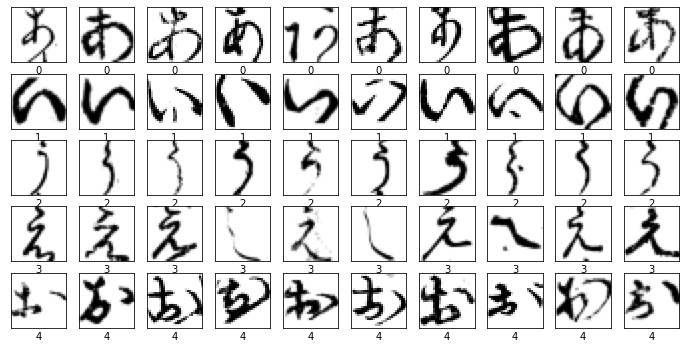

In [ ]:
#Plotando as imagens das vogais (a, i, u, e, o)
def plt_img(img, lb, classes):
    plt.figure(figsize=(12,12))
    print(classes[0], classes[1], classes[2], classes[3], classes[4])
    for i in tqdm_notebook(range(5)):
        imgs = img[np.where(lb == i)]
        lbls = lb[np.where(lb == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])

plt_img(X_train, y_train, classes)

- Separando os dados de treino entre treino e validação

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [ ]:
#Criando a classe do Dataset
class Kmnist(Dataset):
    def __init__(self, datax, datay, transform=None):        
        self.x_kmnist = list(datax)
        self.y_kmnist = list(datay)
        self.transform = transform
        
        self.labels = np.asarray(self.y_kmnist)
        self.images = np.asarray(self.x_kmnist).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

## Connected Neural Network: LeNet-5

LeNet foi uma das primeiras Redes Neurais Convolucionais, criada originalmente para o dataset MNIST. Sua arquitetura consiste em dois grupos de layers de pooling médio e convolucional, um layer de achatamento convolucional, dois layers totalmente conectados e, por último, um classificador ReLU.

In [ ]:
LeTransform = transforms.Compose([
    transforms.ToTensor()
])

lenet_train = DataLoader(Kmnist(X_train, y_train, transform=LeTransform), batch_size=BATCH_SIZE, shuffle=True)
lenet_valid = DataLoader(Kmnist(X_valid, y_valid, transform=LeTransform), batch_size=BATCH_SIZE, shuffle=True)
lenet_test = DataLoader(Kmnist(X_test, y_test, transform=LeTransform), batch_size=BATCH_SIZE, shuffle=True)

Arquitetura da LeNet:

- Primeira layer convolucional: entrada de um canal para 6 feature maps e kernel 5x5
- Segunda layer convlucional: entrada de 6 canais e saída de 32, kernel 5x5
- Primeira layer fully-connected: ligando 32 feature maps a 120 unidades de saída
- Segunda layer fully-connected: liga 120 entradas a 84 unidades de saída
- Terceira layer fully-connected: liga 84 entradas a 10 unidades de saída

Aplicação:

- Aplica-se primeira layer convolucional seguida de ReLU e maxpooling
- Aplica-se segunda layer convolucional seguida de ReLU e maxpooling
- Transforma o dado da imagem em um único vetor
- Aplica a primeira layer fully-connected seguida de ReLU
- Aplica a segunda layer fully-connected seguida de ReLU
- Aplica a terceira layer fully-connected

In [ ]:
class leNet(nn.Module):
    def __init__(self):
        super(leNet, self).__init__()
        self.cv1 = nn.Conv2d(1, 6, 5, 1,  2)
        self.cv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 49)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.cv1(x)), 2)
        x = F.max_pool2d(F.relu(self.cv2(x)), 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = leNet().to(DEVICE)

- Para a escolha dos parâmetros, utilizamos uma taxa aprendizado de 0.001

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_lenet = optim.SGD(lenet.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
# Iterando sobre os dados de treino
n = ((X_train.shape[0]) // BATCH_SIZE)
lenet_loss = []
lenet_train_acc = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(lenet_train):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer_lenet.zero_grad()

        outputs = lenet(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer_lenet.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        running_loss += loss.item()
        if (batch_idx == n/2) or (batch_idx == n-1):
            print('[Epoch %2d] loss: %.3f' % (epoch + 1, running_loss/n))
            lenet_loss.append(running_loss/n)
            running_loss = 0.0
            
    lenet_train_acc.append(100 * correct / total)

print('Finished Training LeNet')

[Epoch  1] loss: 0.570
[Epoch  1] loss: 0.212
[Epoch  2] loss: 0.156
[Epoch  2] loss: 0.138
[Epoch  3] loss: 0.114
[Epoch  3] loss: 0.113
[Epoch  4] loss: 0.096
[Epoch  4] loss: 0.099
[Epoch  5] loss: 0.086
[Epoch  5] loss: 0.089
[Epoch  6] loss: 0.077
[Epoch  6] loss: 0.083
[Epoch  7] loss: 0.072
[Epoch  7] loss: 0.078
[Epoch  8] loss: 0.067
[Epoch  8] loss: 0.074
[Epoch  9] loss: 0.062
[Epoch  9] loss: 0.071
[Epoch 10] loss: 0.060
[Epoch 10] loss: 0.067
Finished Training LeNet


In [ ]:
# Salvando o modelo treinado
PATH = './kmnist_lenet.pth'
torch.save(lenet.state_dict(), PATH)

In [ ]:
# Testando a acurácia da rede para o conjunto de validação
correct = 0
total = 0

with torch.no_grad():
    for data, target in lenet_valid:
        target = target.type(torch.LongTensor)
        images, target = data.to(DEVICE), target.to(DEVICE)
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

lenet_valid_acc = 100 * correct / total
print('Acurácia da rede nas imagens de validação: %d %%' % lenet_valid_acc)

Acurácia da rede nas imagens de validação: 94 %


In [ ]:
# Testando a acurácia da rede em todo o conjunto de teste
correct = 0
total = 0

with torch.no_grad():
    for data, target in lenet_test:
        target = target.type(torch.LongTensor)
        images, target = data.to(DEVICE), target.to(DEVICE)
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

lenet_test_acc = 100 * correct / total
print('Acurácia da rede nas imagens de teste: %d %%' % lenet_test_acc)

Acurácia da rede nas imagens de teste: 90 %


In [ ]:
# Avaliando a acurácia em cada classe
class_correct = list(0. for i in range(49))
class_total = list(0. for i in range(49))

with torch.no_grad():
    for data, target in lenet_test:
        target = target.type(torch.LongTensor)
        images, target = data.to(DEVICE), target.to(DEVICE)
        outputs = lenet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(3):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

lenet_class_acc = []
for i in range(10):
    lenet_class_acc.append(100 * class_correct[i] / class_total[i])
print('Verificação de acurácia por classes terminada!')

Verificação de acurácia por classes terminada!


## Connected Neural Network: AlexNet

AlexNet é uma Rede Neural Convolucional criada por Alex Krizhevsky que ficou no Top-5 do Desafio de Reconhecimento de Imagens da ImageNet, em 2012.
Sua arquitetura é formada por 5 layers convolucionais seguidas de 3 fully connected, além de usar ReLu como função de ativação.


- Como a entrada do AlexNet recebe apenas imagens 227x227 e o KMINIST tem 28x28, será necessário redimensionar as imagens.
- Como o *torchvision.transform.Resize* só aceita imagens PIL, elas são convertidas para este formato dentro da classe.

In [ ]:
#Preparando os dados para o AlexNet
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = DataLoader(Kmnist(X_train, y_train, transform=AlexTransform), batch_size=BATCH_SIZE, shuffle=True)
valid = DataLoader(Kmnist(X_valid, y_valid, transform=AlexTransform), batch_size=BATCH_SIZE, shuffle=True)
test = DataLoader(Kmnist(X_test, y_test, transform=AlexTransform), batch_size=BATCH_SIZE, shuffle=True)

Arquitetura da AlexNet:

- Primeira layer convolucional: entrada de 1 canal para 96 feature maps, kernel 11x11, stride=4 e padding=0
- Segunda layer convlucional: entrada de 96 canais e saída de 256, kernel 5x5, stride=1 e padding=2
- Terceira layer convlucional: entrada de 256 canais e saída de 384, kernel 3x3, stride=1 e padding=1
- Quarta layer convlucional: entrada de 384 para 384, kernel 3x3, stride=1 e padding=1
- Quinta layer convlucional: entrada de 384 canais e saída de 256, kernel 3x3, stride=1 e padding=1
- Primeira layer fully-connected: ligando os feature maps de entrada a 4096 unidades de saída
- Segunda layer fully-connected: liga 4096 entradas a 4096 unidades de saída
- Terceira layer fully-connected: liga 4096 entradas a 10 unidades de saída

Aplicação:

- A primeria layer convolucional é aplicada e seguida de ReLu e MaxPool de kernel 3x3 e stride=2
- A segunda layer convolucional é aplicada e seguida de ReLu e MaxPool de kernel 3x3 e stride=2
- A terceira layer convolucional é aplicada e seguida de ReLu
- A quarta layer convolucional é aplicada e seguida de ReLu
- A quinta layer convolucional é aplicada e seguida de ReLu e MaxPool de kernel 3x3 e stride=2
- Os dados da imagem são transformados em um único vetor
- Aplica-se a primeira layer fully-connected seguida de ReLU
- Aplica-se a segunda layer fully-connected seguida de ReLU
- Aplica-se a terceira layer fully-connected
- Aplica-se softmax seguido de logaritmo

In [ ]:
#Criando a classe da CNN
class AlexNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.cv1 = nn.Sequential(
                nn.Conv2d(1, 96, 11, 4, 0),
                nn.ReLU(),
                nn.MaxPool2d(3, 2)
            )
            self.cv2 = nn.Sequential(
                nn.Conv2d(96, 256, 5, 1, 2),
                nn.ReLU(),
                nn.MaxPool2d(3, 2)
            )
            self.cv3 = nn.Sequential(
                nn.Conv2d(256, 384, 3, 1, 1),
                nn.ReLU()
            )
            self.cv4 = nn.Sequential(
                nn.Conv2d(384, 384, 3, 1, 1),
                nn.ReLU()
            )
            self.cv5 = nn.Sequential(
                nn.Conv2d(384, 256, 3, 1, 1),
                nn.ReLU(),
                nn.MaxPool2d(3, 2)
            )
            self.fc1 = nn.Linear(256*6*6, 4096)
            self.fc2 = nn.Linear(4096, 4096)
            self.fc3 = nn.Linear(4096, 49)

        def forward(self, x):
            out = self.cv1(x)
            out = self.cv2(out)
            out = self.cv3(out)
            out = self.cv4(out)
            out = self.cv5(out)
            out = out.view(out.size(0), -1)

            out = F.relu(self.fc1(out))
            out = F.dropout(out, 0.5)
            out = F.relu(self.fc2(out))
            out = F.dropout(out, 0.5)
            out = self.fc3(out)
            out = F.log_softmax(out, dim=1)

            return out
        
alexnet = AlexNet().to(DEVICE)

- Para a escolha dos parâmetros, utilizamos uma taxa aprendizado de 0.001

In [ ]:
# Vamos utilizar a loss "Classification Cross-Entropy" e gradiente descentende
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr = 0.001, momentum = 0.9)

### Treinando a Rede

In [ ]:
# Iterando sobre os dados
n = ((X_train.shape[0]) // BATCH_SIZE)
alexnet_loss = []
alexnet_train_acc = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        
        # Forward + Backward + Otimização
        outputs = alexnet(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item() 

        # Printando as estatísticas
        running_loss += loss.item()
        if (batch_idx == n/2) or (batch_idx == n-1):
            print('[Epoch %2d] loss: %.3f' % (epoch + 1, running_loss/n))
            alexnet_loss.append(running_loss/n)
            running_loss = 0.0
            
    alexnet_train_acc.append(100 * correct / total)
    
print('Finished Training on the AlexNet')

[Epoch  1] loss: 0.358
[Epoch  1] loss: 0.107
[Epoch  2] loss: 0.073
[Epoch  2] loss: 0.065
[Epoch  3] loss: 0.049
[Epoch  3] loss: 0.048
[Epoch  4] loss: 0.037
[Epoch  4] loss: 0.038
[Epoch  5] loss: 0.029
[Epoch  5] loss: 0.031
[Epoch  6] loss: 0.025
[Epoch  6] loss: 0.027
[Epoch  7] loss: 0.021
[Epoch  7] loss: 0.023
[Epoch  8] loss: 0.018
[Epoch  8] loss: 0.019
[Epoch  9] loss: 0.017
[Epoch  9] loss: 0.018
[Epoch 10] loss: 0.015
[Epoch 10] loss: 0.017
Finished Training on the AlexNet


In [ ]:
# Salvando o modelo treinado
PATH = './kmnist_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

In [ ]:
# Testando a acurácia da rede para o conjunto de validação
correct = 0
total = 0

with torch.no_grad():
    for data, target in valid:
        target = target.type(torch.LongTensor)
        images, target = data.to(DEVICE), target.to(DEVICE)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item() 
        
alexnet_valid_acc = 100 * correct / total
print('Acurácia da rede nas imagens de validação: %d %%' % alexnet_valid_acc)

Acurácia da rede nas imagens de validação: 97 %


In [ ]:
# Testando a acurácia da rede em todo o conjunto de testes
correct = 0
total = 0

with torch.no_grad():
    for data, target in test:
        target = target.type(torch.LongTensor)
        images, target = data.to(DEVICE), target.to(DEVICE)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
alexnet_test_acc = 100 * correct / total
print('Acurácia da rede nas imagens de teste: %d %%' % alexnet_test_acc)

Acurácia da rede nas imagens de teste: 95 %


In [ ]:
# Avaliando a acurácia em cada classe
class_correct = list(0. for i in range(49))
class_total = list(0. for i in range(49))

with torch.no_grad():
    for data, target in test:
        target = target.type(torch.LongTensor)
        images, target= data.to(DEVICE), target.to(DEVICE)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(3):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

alexnet_class_acc = []            
for i in range(10):
    alexnet_class_acc.append(100 * class_correct[i] / class_total[i])
print('Verificação de acurácia por classes terminada!')

Verificação de acurácia por classes terminada!


## Resultados e Comparação

Apesar da semelhança, tanto de nome quanto de objetivos gerais, o Kuzushiji MNIST é mais desafiador que o MNIST tradicional. Não só por possuir quase cinco vezes mais classes, mas também pelo número de variações. Quanto mais usado o caracter é na escrita, mais diferente ele se torna e um único caractere pode ser escrito de múltiplas maneiras diferentes no Japonês pré-moderno.<br>
O Hiragana foi e ainda é extremamente usado para acompanhar *kanji* em adjetivos e verbos ou substituí-los completamete como acontciam em obras cujas autoras eram mulheres, pois até certo ponto da história, as mulheres não eram ensinadas a escrever *kanji*.<br>
Todos esses fatores comprovam a complexidade do Kuzushiji MNIST e leva à espera de resultados condizentes.

- Não foi  usado cross-validation neste experimento pois deixaria o processo das classificações ainda mais pesado e demorado.

### Acurácia de Treino

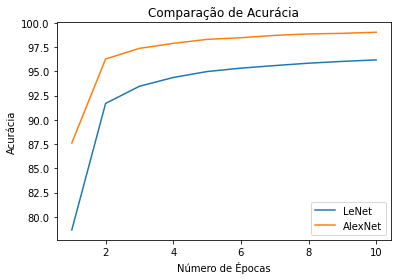

In [ ]:
plt.plot([i for i in range(1, EPOCHS+1)], lenet_train_acc, label = "LeNet")
plt.plot([i for i in range(1, EPOCHS+1)], alexnet_train_acc, label = "AlexNet")
plt.xlabel('Número de Épocas')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia')
plt.legend() 
plt.show()

### Loss do treino

In [ ]:
grafx=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

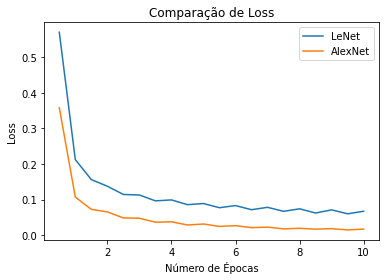

In [ ]:
plt.plot(grafx, lenet_loss, label = "LeNet")
plt.plot(grafx, alexnet_loss, label = "AlexNet")
plt.xlabel('Número de Épocas')
plt.ylabel('Loss')
plt.title('Comparação de Loss')
plt.legend() 
plt.show()

### Comparação das Acurácias

- Acurácia de Validação

| Rede | MNIST | KMNIST |
|---|---|---|
| AlexNet | 0% | 0% |
| LeNet | 0% | 0% |

- Acurácia de Teste

| Rede | MNIST | KMNIST |
|---|---|---|
| AlexNet | 0% | 0% |
| LeNet | 0% | 0% |

- Acurácia por classe para as 10 primeiras classes

In [ ]:
table_val = []
for cont in range(10):
    table_val.append([classes[cont], round(lenet_class_acc[cont], 2), round(alexnet_class_acc[cont], 2)])

acc_df = pd.DataFrame(np.array(table_val), columns=['Classes', 'LeNet', 'AlexNet'])
acc_df

,Classes,LeNet,AlexNet
0,あ,92.65,96.97
1,い,92.84,97.51
2,う,95.56,95.95
3,え,91.92,90.65
4,お,92.4,96.51
5,か,80.61,88.99
6,き,88.08,96.4
7,く,91.09,92.7
8,け,87.76,97.19
9,こ,89.88,91.86


## Conclusão



## Referências

- T. Clanuwat, A. Kitamoto, K. Yamamoto, M. Bober-Irizar, A. Lamb and D. Ha. **Deep Learning for Classical Japanese Literature**. 32nd Conference on Neural Information Processing Systems, Montreal, Canadá, p. 1-5, dec. 2018. Disponível em: https://arxiv.org/pdf/1812.01718.pdf

- T. Clanuwat, A. Lamb and A. Kitamoto. **KuroNet: Pre-Modern Japanese Kuzushiji Character Recognition with Deep Learning**. p.1-5. Disponível em: https://arxiv.org/pdf/1910.09433.pdf

- anokas.**Kuzushiji-MNIST: Classify handwritten characters in ancient Japanese manuscripts**. Kaggle, CC BY-SA 4.0, 2018. Disponível em: https://www.kaggle.com/anokas/kuzushiji

- Tiiktak.**Fashion MNIST with AlexNet in Pytorch(92% accuracy**. Kaggle, Mar. 2020. Disponível em: https://www.kaggle.com/tiiktak/fashion-mnist-with-alexnet-in-pytorch-92-accuracy

- A. Krizhevsky, I. Sutskever and G.E. Hinton.**ImageNet Classification with Deep Convolutional Neural Networks**. p. 5, 2012. Disponível em: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

- Y. LeCun, L. Bottou, Y Bengio and P. Haffner.**Gradient-Based Learning Applied to Document Recognition**.PROC OF THE IEEE, Nov. 1998. Disponível em: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
